# Proportion of all edits to the main namespace made with that include new content

**Megan Neisler, Senior Data Scientist, Wikimedia Foundation**

[TASK](https://phabricator.wikimedia.org/T344132)

**Last update: 16 August 2023**


In [1]:
shhh <- function(expr) suppressPackageStartupMessages(suppressWarnings(suppressMessages(expr)))
shhh({
    library(tidyverse)
    library(glue)
    # Tables:
    library(gt)
    library(gtsummary)
})

In [2]:
options(repr.plot.width = 15, repr.plot.height = 10)
# Suppress summarise info
options(dplyr.summarise.inform = FALSE)

# Methodology

Method: Checked for all edits tagged with the `visualeditor` tag in the mediawiki_revision_tags_change table and identifed the proportion of these edits that were also tagged as including new content (`editcheck-newcontent`). Data imited to main namespace (NP: 0) pages on Wikipedia pages and edits that occured after the hidden new content tag was added. 

Data comes comes the `mediawiki_revision_tags_change` table. Data reviewed was limited to revisions with a timestamp of july 7th or later to reflect when both change tags were deployed. 

From Peter: proportion of all edits to the main namespace made with VE [ii] that involve people adding new new content, overall and broken out by project and experience level?

# Explore Data

In [46]:
new_content_edit_data <-
  read.csv(
    file = 'Data/ve_new_content.csv',
    header = TRUE,
    sep = ",",
    stringsAsFactors = FALSE
  ) # loads all revert data

In [47]:
# Clean data

# group user edit count 
new_content_edit_data  <- new_content_edit_data  %>%
 mutate(
    user_edit_count_group = case_when(
      user_edit_count == 'NA'  ~ "unregistered",
      user_edit_count == 0 ~ "new editor",
      user_edit_count  > 0 & user_edit_count < 100 ~ "1-100 edits",
       user_edit_count  >= 100 & user_edit_count <= 500 ~ "100-500 edits",
      user_edit_count > 500 ~ '500+ edits'  
    )
  ) 

# add factor levels to exp level
new_content_edit_data$user_edit_count_group <-
  factor(new_content_edit_data$user_edit_count_group,
         levels = c("new editor", "1-100 edits", "100-500 edits", "500+ edits"))

# Overall

## Proportion of edits

In [6]:
ve_new_content_overall <- new_content_edit_data %>%
    summarise(
        n_edits = n_distinct(rev_id),
        n_edit_w_content = n_distinct(rev_id[includes_new_content > 0]),
        pct_new_content_edits = n_edit_w_content/n_edits * 100)

ve_new_content_overall

n_edits n_edit_w_content pct_new_content_edits
1 680756  88523            13.00363

Overall 13% of all VE edits to a main namespace involved people adding new new content (defined as meeting the requirements of the new content tag). 

## Proportion of users

In [7]:
ve_new_content_overall_users <- new_content_edit_data  %>%
    summarise(
        n_users = n_distinct(user),
        n_users_w_content = n_distinct(user[includes_new_content > 0]),
        pct_new_content_users = n_users_w_content/n_users * 100)

ve_new_content_overall_users

n_users n_users_w_content pct_new_content_users
1 128420  32927             25.64009

# By Logged In Status

In [14]:
ve_new_content_overall <- new_content_edit_data %>%
    group_by(user_status) %>%
    summarise(
        n_edits = n_distinct(rev_id),
        n_edit_w_content = n_distinct(rev_id[includes_new_content > 0]),
        pct_new_content_edits = n_edit_w_refs/n_edits * 100)

ve_new_content_overall

user_status  n_edits n_edit_w_refs pct_new_content_edits
1 registered   533965  70305         13.16659             
2 unregistered 147106  18228         12.39106

In [ ]:
Not too big of a difference between rates by registered and unregistred users. Registered users are just slightly more likely to add new content.

# By User Experience Level

## Proportion of edits

In [9]:
ve_new_content_exp <- new_content_edit_data %>%
  filter(user_status != 'unregistered') %>% #remove logged out users
    group_by(user_edit_count_group) %>%
    summarise(
        n_edits = n_distinct(rev_id),
        n_edit_w_content = n_distinct(rev_id[includes_new_content > 0]),
        pct_new_content_edits = round(n_edit_w_content/n_edits, 2))

ve_new_content_exp

user_edit_count_group n_edits n_edit_w_content pct_new_content_edits
1 new editor             15953   3763            0.24                 
2 1-100 edits           134654  19704            0.15                 
3 100-500 edits          83546   9740            0.12                 
4 500+ edits            299918  37101            0.12

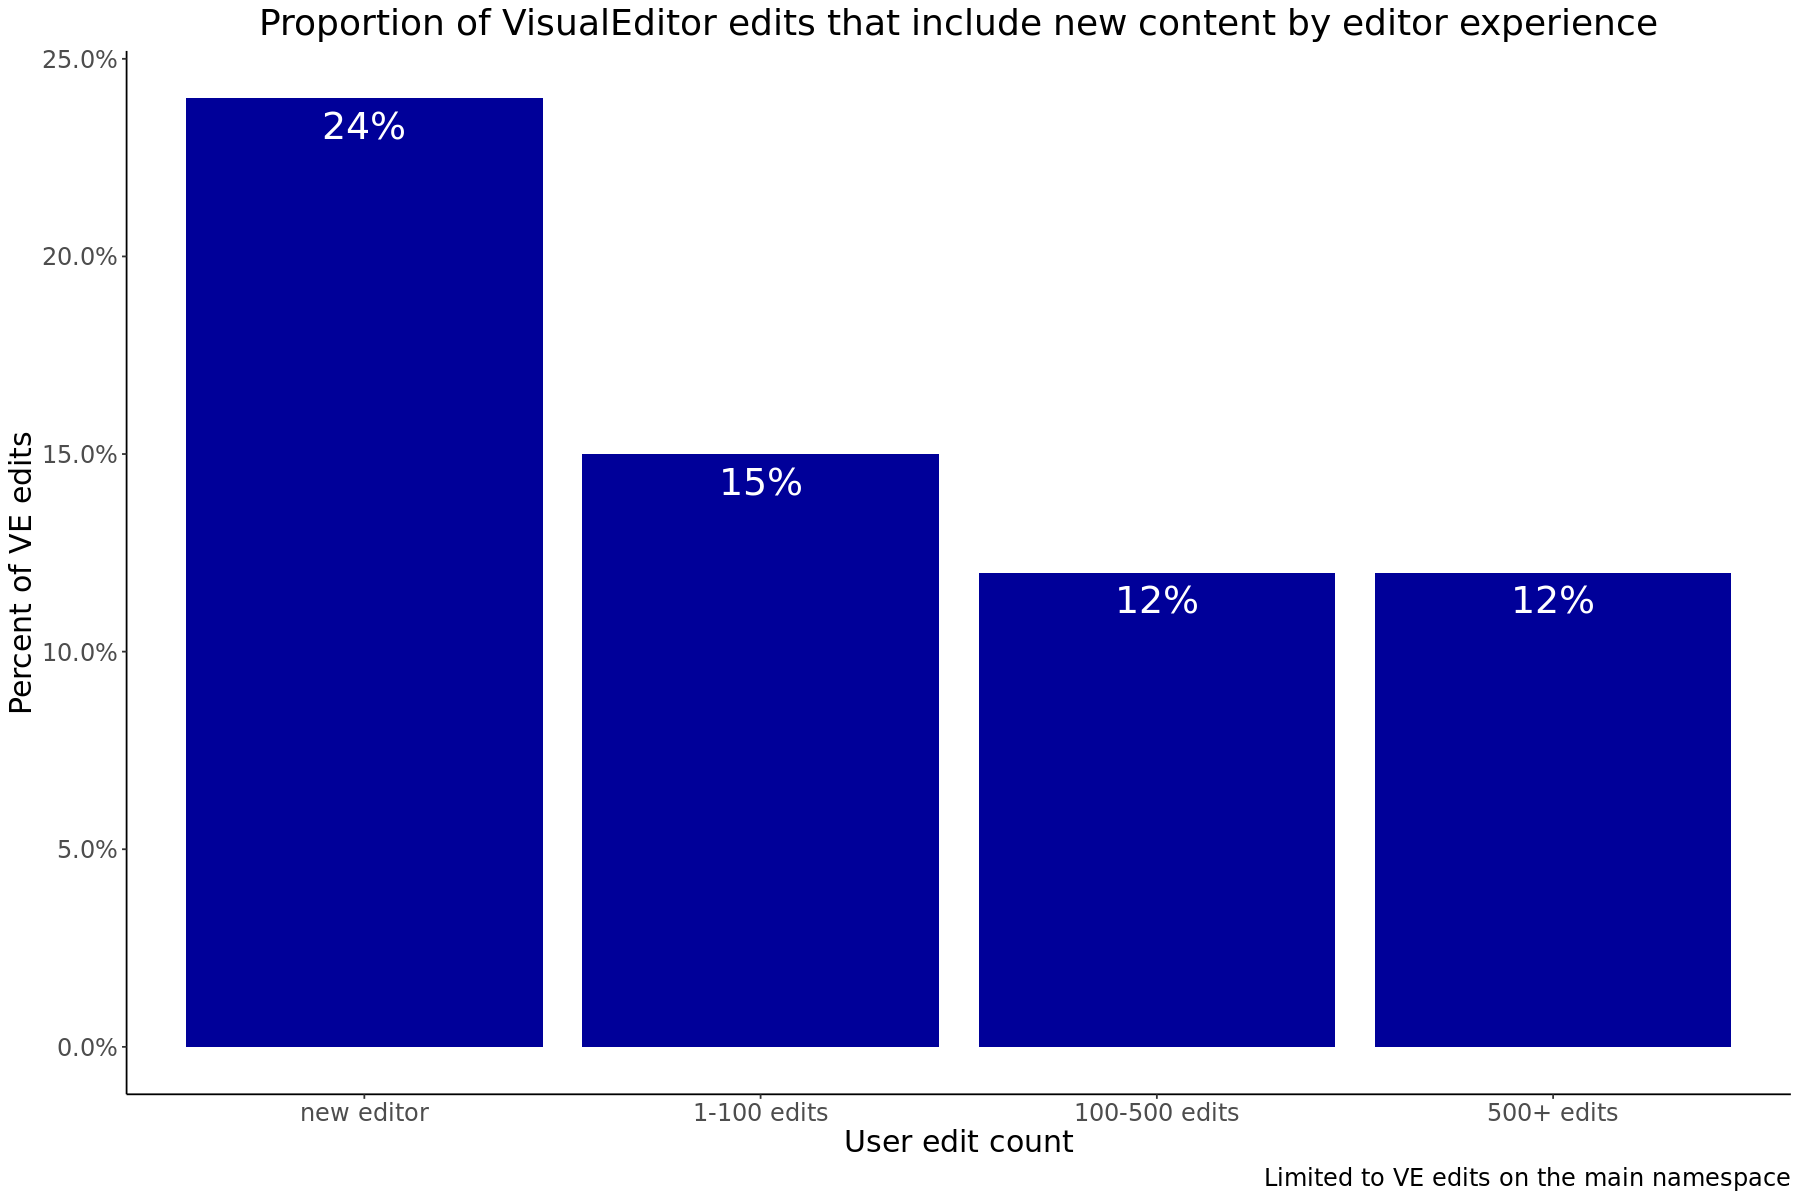

In [37]:
p <- ve_new_content_exp %>%
        ggplot(aes(x = user_edit_count_group, y= pct_new_content_edits)) +
        geom_col(position = 'dodge', fill = '#000099') +
        geom_text(aes(label = paste0(pct_new_content_edits * 100,'%')), color = "white", vjust=1.5, size = 8) +
        labs (x = "User edit count",
              y = "Percent of VE edits",
             title = "Proportion of VisualEditor edits that include new content by editor experience",
             caption = "Limited to VE edits on the main namespace") +
        scale_y_continuous(labels = scales::percent) +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=18),
            axis.line = element_line(colour = "black"),
            legend.position = "none")
      
p


* The proportion of edits that include new content decreases as editor experience increases. A higher percentage of VE edits by new editors (24%) include new content than VE edits by senior contributors with 100-500 edits (12%) or over 500+ edits (12%).
* There are only slight decreases in the percentage of VE edits with new content between junior and senior contributors. We see a higher percent change from new editors to Junior Contributors (-37.5% decrease in the percent of edits with new content).

## Proportion of users

In [23]:
ve_new_content_exp_users <- new_content_edit_data  %>%
    filter(user_edit_count_group != 'unregistered') %>% #remove logged out users
    group_by(user_edit_count_group) %>%
    summarise(
        n_users = n_distinct(user),
        n_users_w_content = n_distinct(user[includes_new_content > 0]),
        pct_new_content_users = round(n_users_w_content/n_users,2))

ve_new_content_exp_users

user_edit_count_group n_users n_users_w_content pct_new_content_users
1 new editor            15182    3679             0.24                 
2 1-100 edits           35373   10170             0.29                 
3 100-500 edits          8877    3036             0.34                 
4 500+ edits            10617    5057             0.48

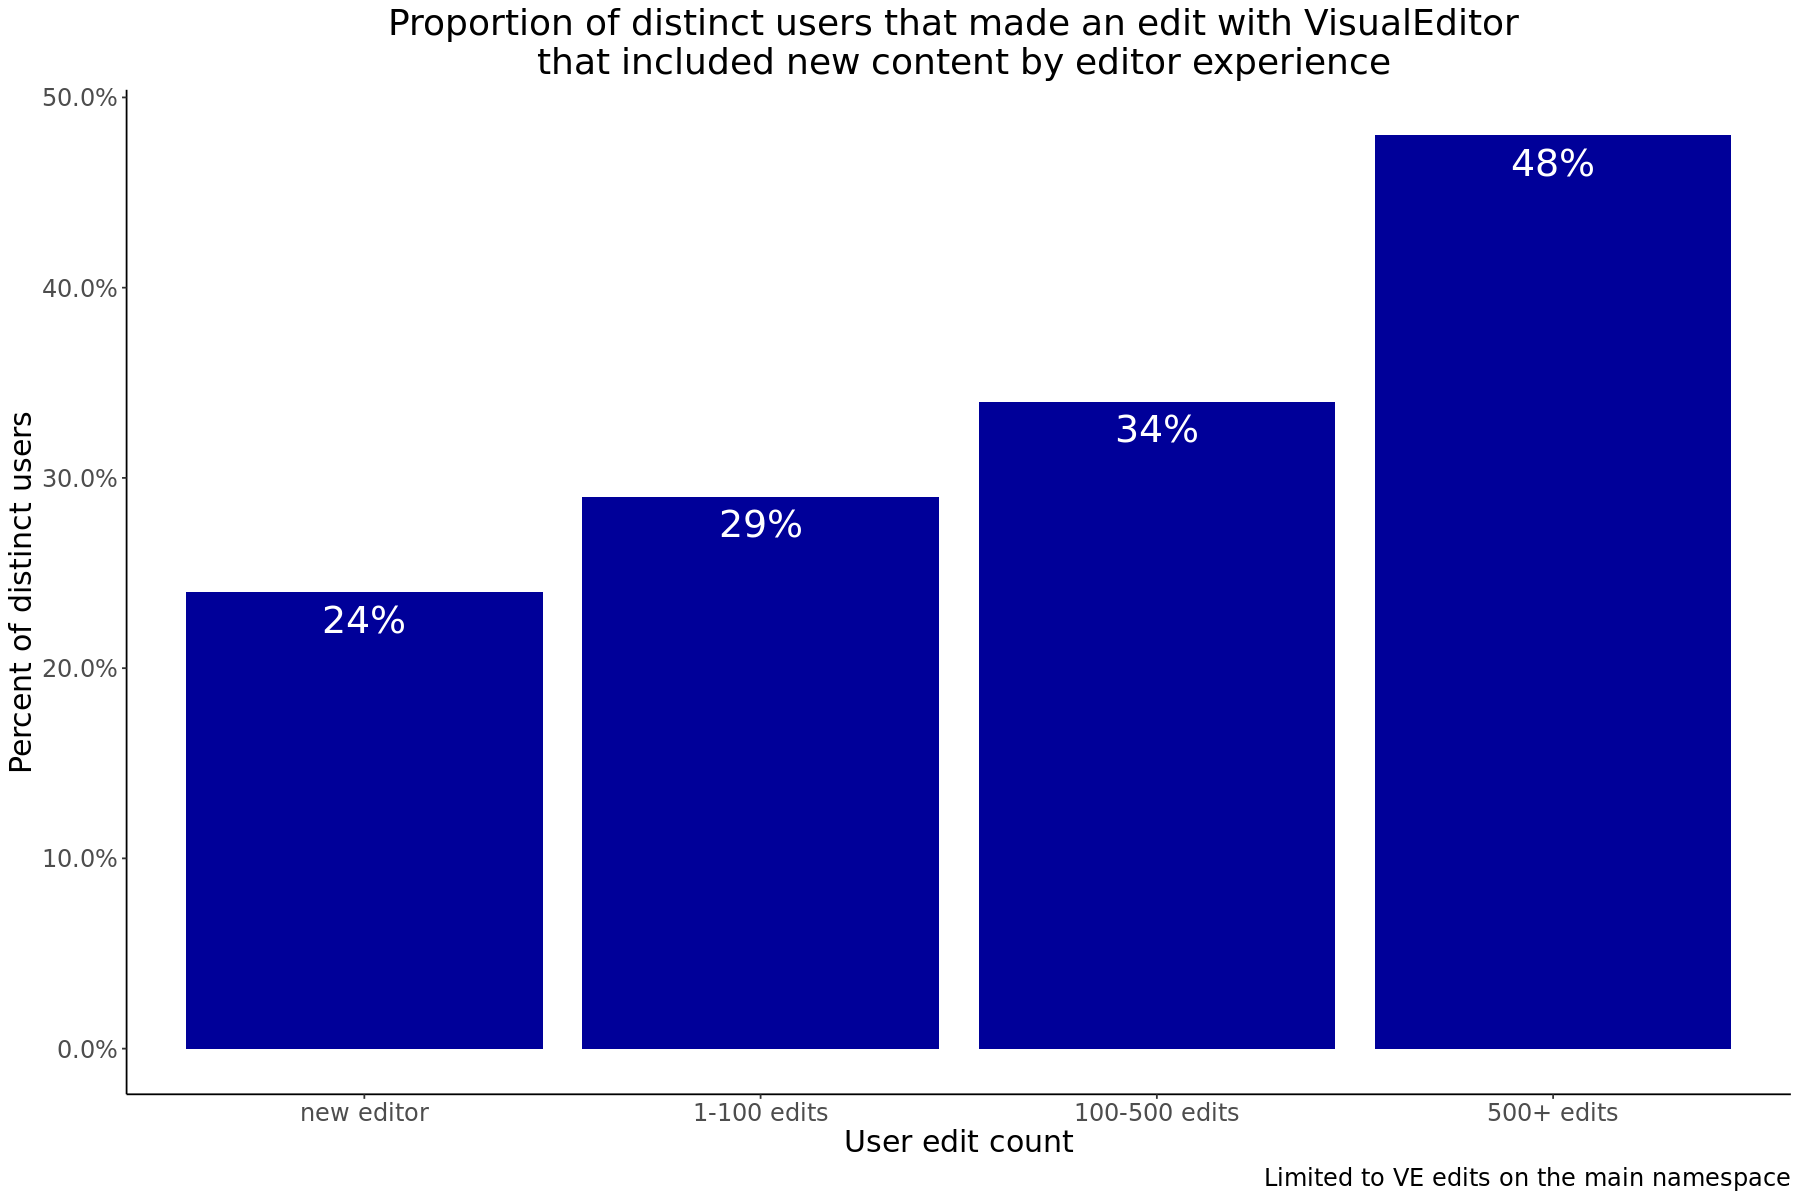

In [27]:
p <- ve_new_content_exp_users %>%
        ggplot(aes(x = user_edit_count_group, y= pct_new_content_users)) +
        geom_col(position = 'dodge', fill = '#000099') +
        geom_text(aes(label = paste0(pct_new_content_users * 100,'%')), color = "white", vjust=1.5, size = 8) +
        labs (x = "User edit count",
              y = "Percent of distinct users",
             title = "Proportion of distinct users that made an edit with VisualEditor \n that included new content by editor experience",
             caption = "Limited to VE edits on the main namespace") +
        scale_y_continuous(labels = scales::percent) +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=18),
            axis.line = element_line(colour = "black"),
            legend.position = "none")
      
p

Note: By definition, there cannot be a new editor that edits multiple times. As soon as new editor, edits a second time they would be considered a Junior Contributor. 

# By Wiki

In [48]:
# add factor levels to project level to order from descreasing to increasing order
new_content_edit_data$wiki<-
  factor(new_content_edit_data$wiki,
         levels = c('swwiki', 'yowiki','igwiki',  'afwiki','arwiki', 'hawiki', 'ptwiki', 'frwiki', 'enwiki', 'dewiki'))

In [ ]:
ve_new_content_wiki <- new_content_edit_data %>%
  filter(wiki %in% c('enwiki', 'frwiki', 'swwiki', 'arwiki', 'ptwiki', 'hawiki', 
                       'igwiki', 'afwiki', 'yowiki', 'dewiki') 
        ,user_status != 'unregistered') %>% #remove logged out users
    group_by(wiki) %>%
    summarise(
        n_edits = n_distinct(rev_id),
        n_edit_w_content = n_distinct(rev_id[includes_new_content > 0]),
        pct_new_content_edits = round(n_edit_w_content/n_edits, 3))

ve_new_content_wiki

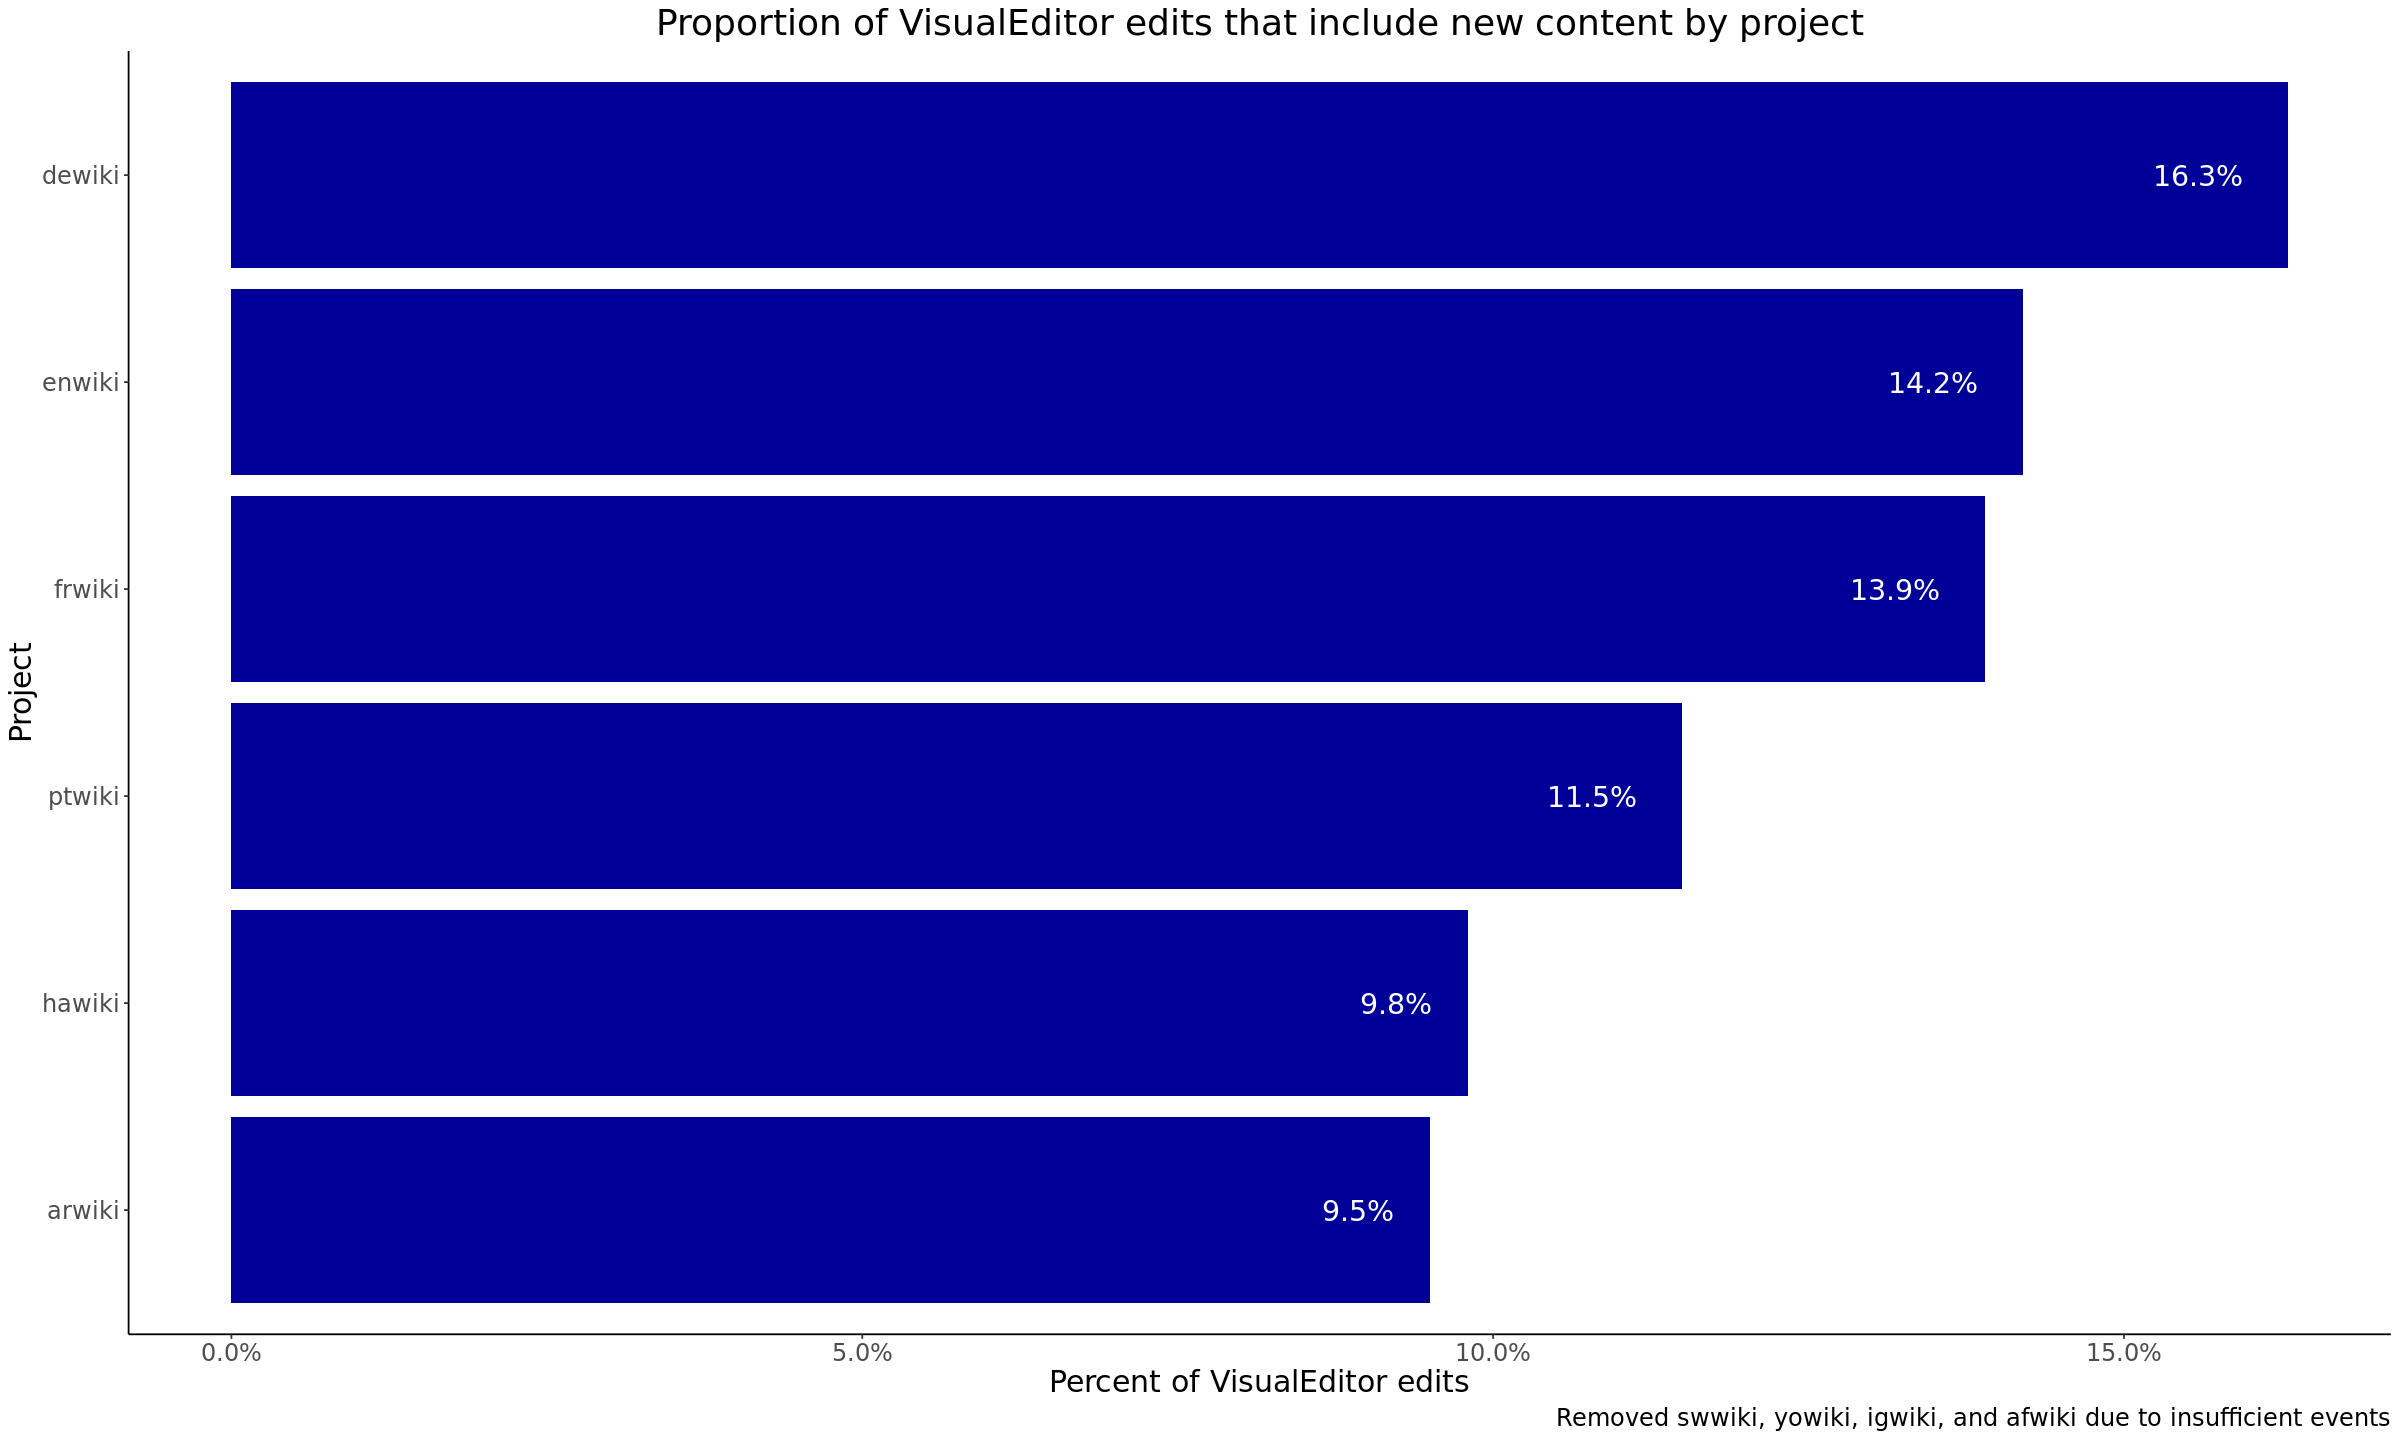

In [52]:
p <- ve_new_content_wiki %>%
         filter(!wiki %in% c('swwiki', 'yowiki', 'igwiki', 'afwiki')) %>%
        ggplot(aes(x = wiki, y= pct_new_content_edits)) +
        geom_col(position = 'dodge', fill = '#000099') +
        geom_text(aes(label = paste0(pct_new_content_edits * 100,'%')), color = "white", hjust= 1.5, size = 6) +
        coord_flip() +
        labs (x = "Project",
              y = "Percent of VisualEditor edits",
             title = "Proportion of VisualEditor edits that include new content by project",
             caption = "Removed swwiki, yowiki, igwiki, and afwiki due to insufficient events") +
        scale_y_continuous(labels = scales::percent) +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=18),
            axis.line = element_line(colour = "black"),
            legend.position = "none")
      
p

* Note: Removed swwiki, yowiki, igwiki, and afwiki due to insufficient VE edits made during the reviewed timeframe.
* German Wikipedia (dewiki) had the highest percentage of VE edits that included new content (16.3%) while Arabic Wikipedia (arwiki) had the lowest (9.5%). 
* Generally, the larger wikis based on edits size had the highest percentage of VE edits with new content. 

# By Wiki and Experience Level

## Proportion of edits

In [ ]:
ve_new_content_exp_wiki <- new_content_edit_data %>%
  filter(wiki %in% c('enwiki', 'frwiki', 'swwiki', 'arwiki', 'ptwiki', 'hawiki', 
                       'igwiki', 'afwiki', 'yowiki', 'dewiki') 
        ,user_status != 'unregistered') %>% #remove logged out users
    group_by(wiki, user_edit_count_group) %>%
    summarise(
        n_edits = n_distinct(rev_id),
        n_edit_w_content = n_distinct(rev_id[includes_new_content > 0]),
        pct_new_content_edits = round(n_edit_w_content/n_edits, 2))

ve_new_content_exp_wiki 

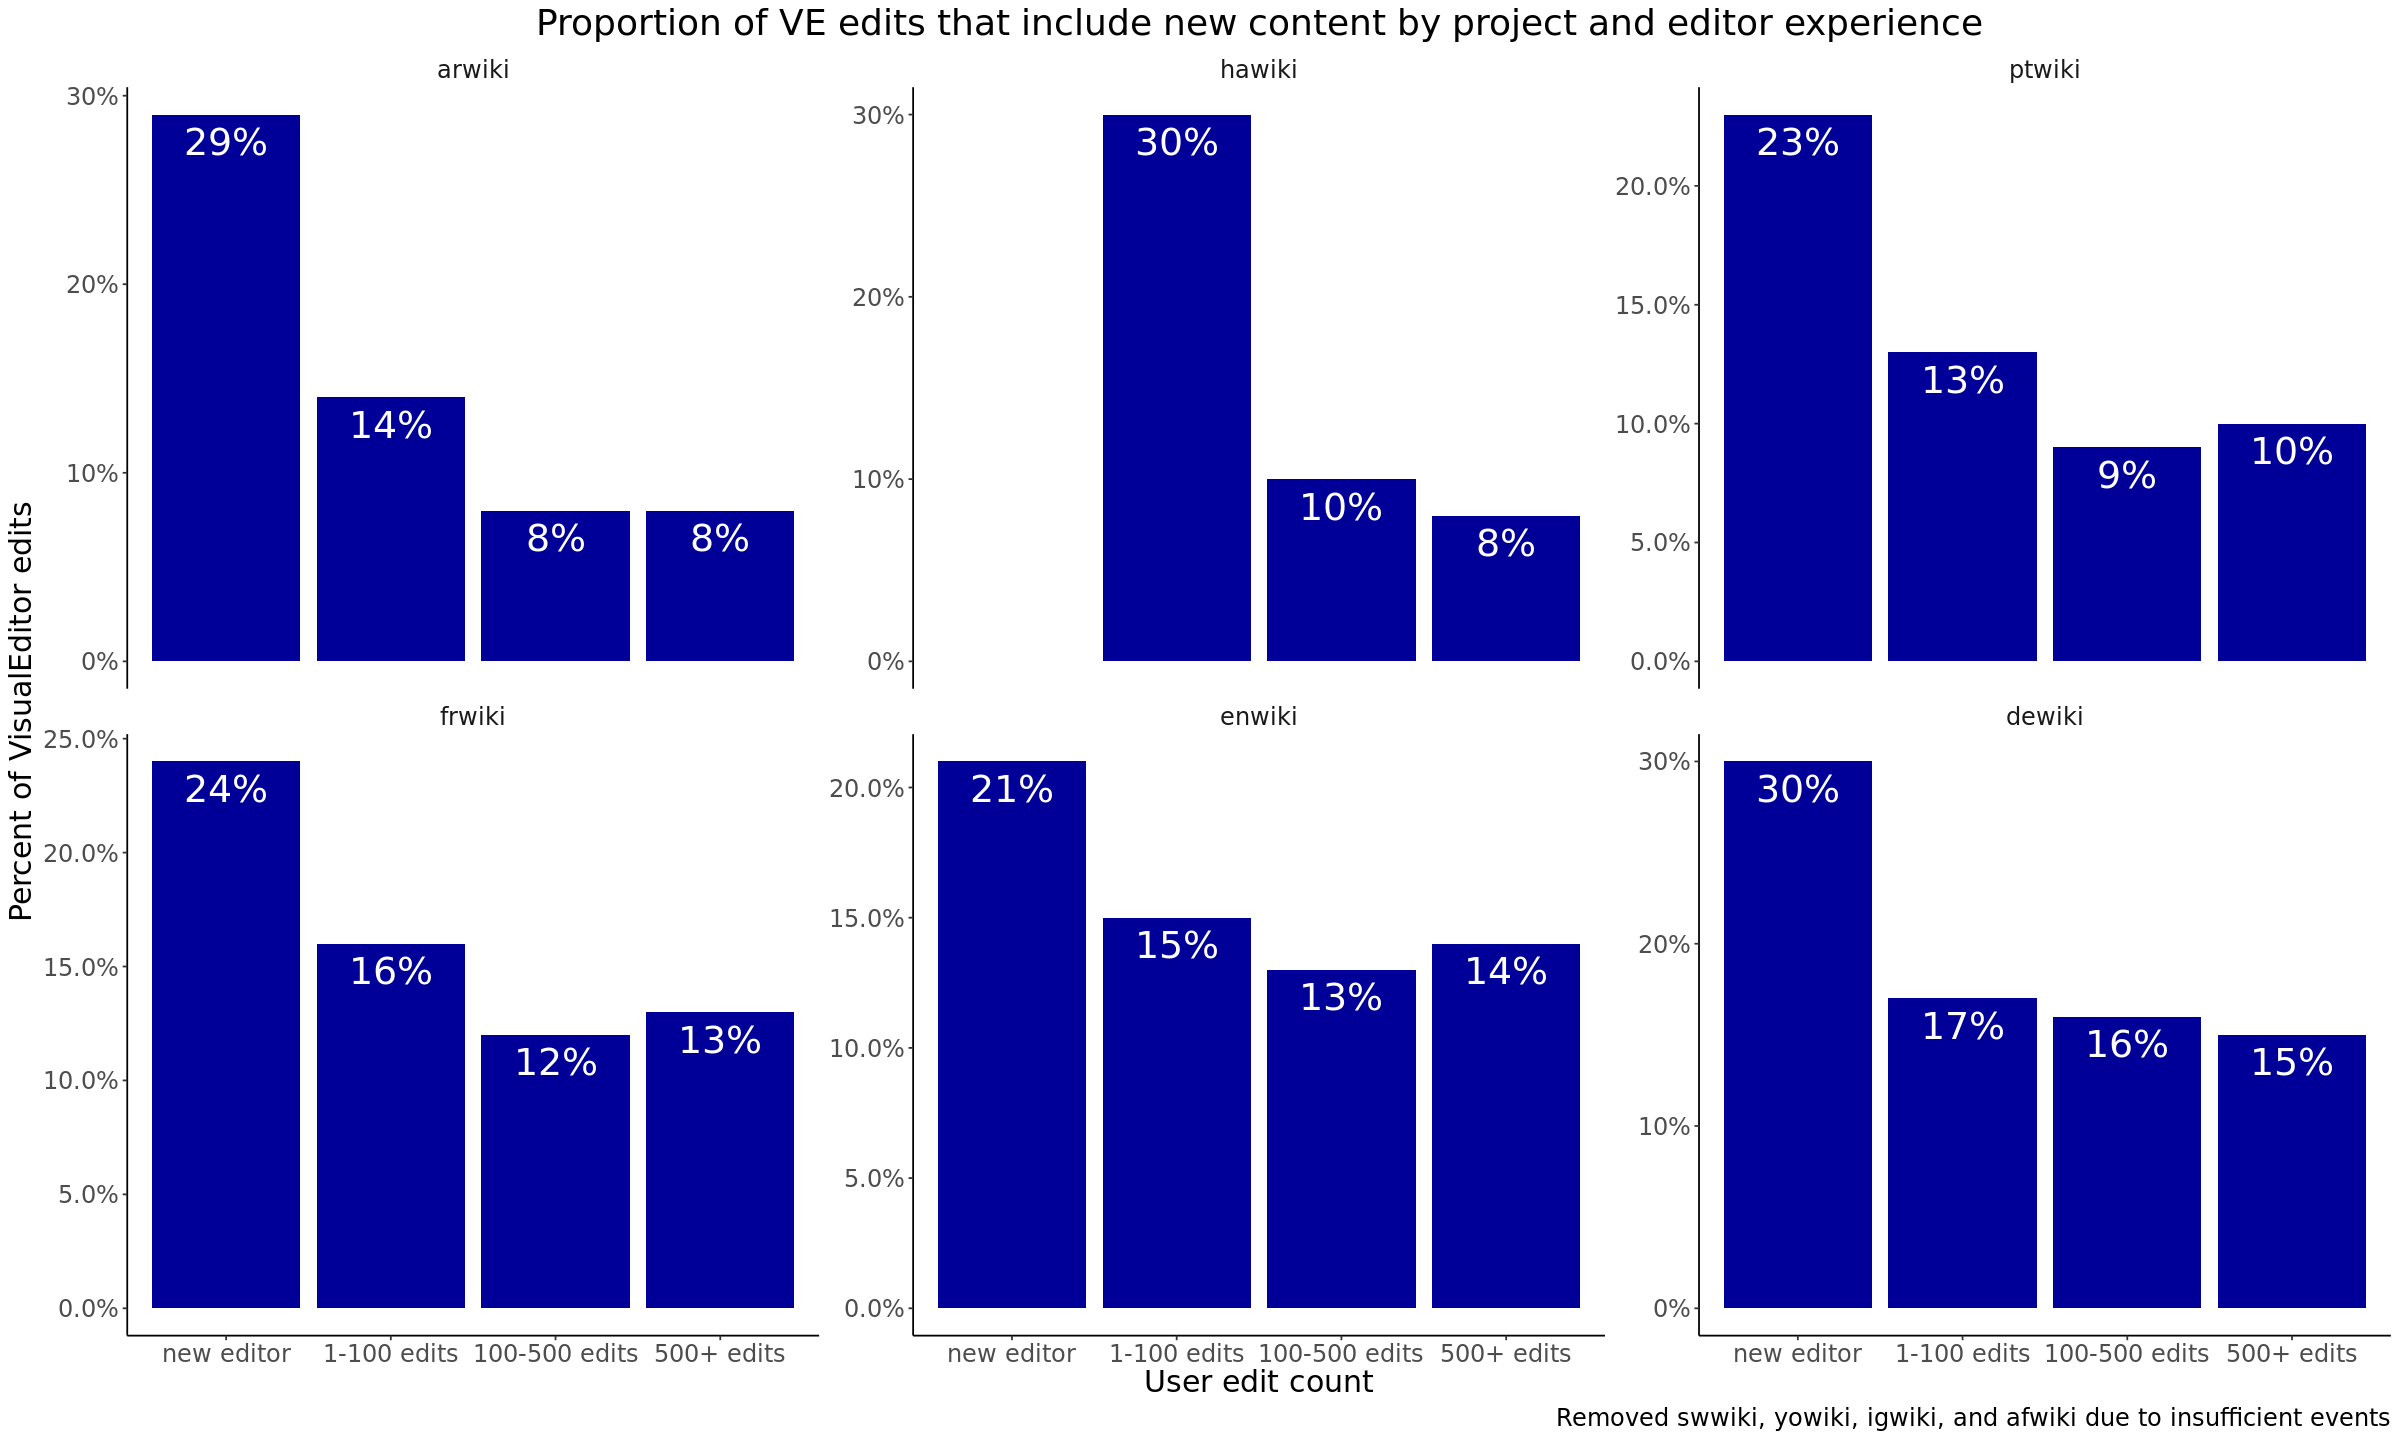

In [54]:
options(repr.plot.width = 20, repr.plot.height = 12)

p <- ve_new_content_exp_wiki  %>% 
         filter(!wiki %in% c('swwiki', 'yowiki', 'igwiki', 'afwiki')) %>%
        ggplot(aes(x = user_edit_count_group, y= pct_new_content_edits)) +
        geom_col(position = 'dodge', fill = '#000099') +
        geom_text(aes(label = paste0(pct_new_content_edits * 100,'%')), color = "white", vjust=1.5, size = 8) +
        facet_wrap(~wiki, scales = "free_y") +
        labs (x = "User edit count",
              y = "Percent of VisualEditor edits",
             title = "Proportion of VE edits that include new content by project and editor experience",
             caption = "Removed swwiki, yowiki, igwiki, and afwiki due to insufficient events") +
        scale_y_continuous(labels = scales::percent) +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=18),
            axis.line = element_line(colour = "black"),
            legend.position = "none")
      
p


* The proportion of VE edits that include new content generally decreases with editor experience at each reviewed project.
* Arwiki, Hawiki and Ptwiki have the smallest proportion of edits by senior editors (500+ edits) that include new content, ranging from 8 to 10% of all VE edits. 
* Hawiki did not have any new content edits by new editors during the reviewed time period.  
* At each project, there is minimal difference in the proportion of edits that include new content by editors with 100-500 edits and 500+ edits but we see a larger percent change between new editors and junior editors (1-100 edits).
   * At enwiki, 21% of VE edits by new editors included new content compared to 14% by Junior Contributors  (-33.3% decrease).
   * At dewiki,   30% of VE edits by new editors included new content compared to 15% by Junior Contributors  (-50% decrease).

## Proportion of users

In [35]:
ve_new_content_exp_wiki_user  <- new_content_edit_data %>%
  filter(wiki %in% c('enwiki', 'frwiki', 'swwiki', 'arwiki', 'ptwiki', 'hawiki', 
                       'igwiki', 'afwiki', 'yowiki', 'dewiki') 
        ,user_status != 'unregistered') %>% #remove logged out users
    group_by(wiki, user_edit_count_group) %>%
    summarise(
        n_users = n_distinct(user),
        n_users_w_content = n_distinct(user[includes_new_content > 0]),
        pct_new_content_users = round(n_users_w_content/n_users, 2))


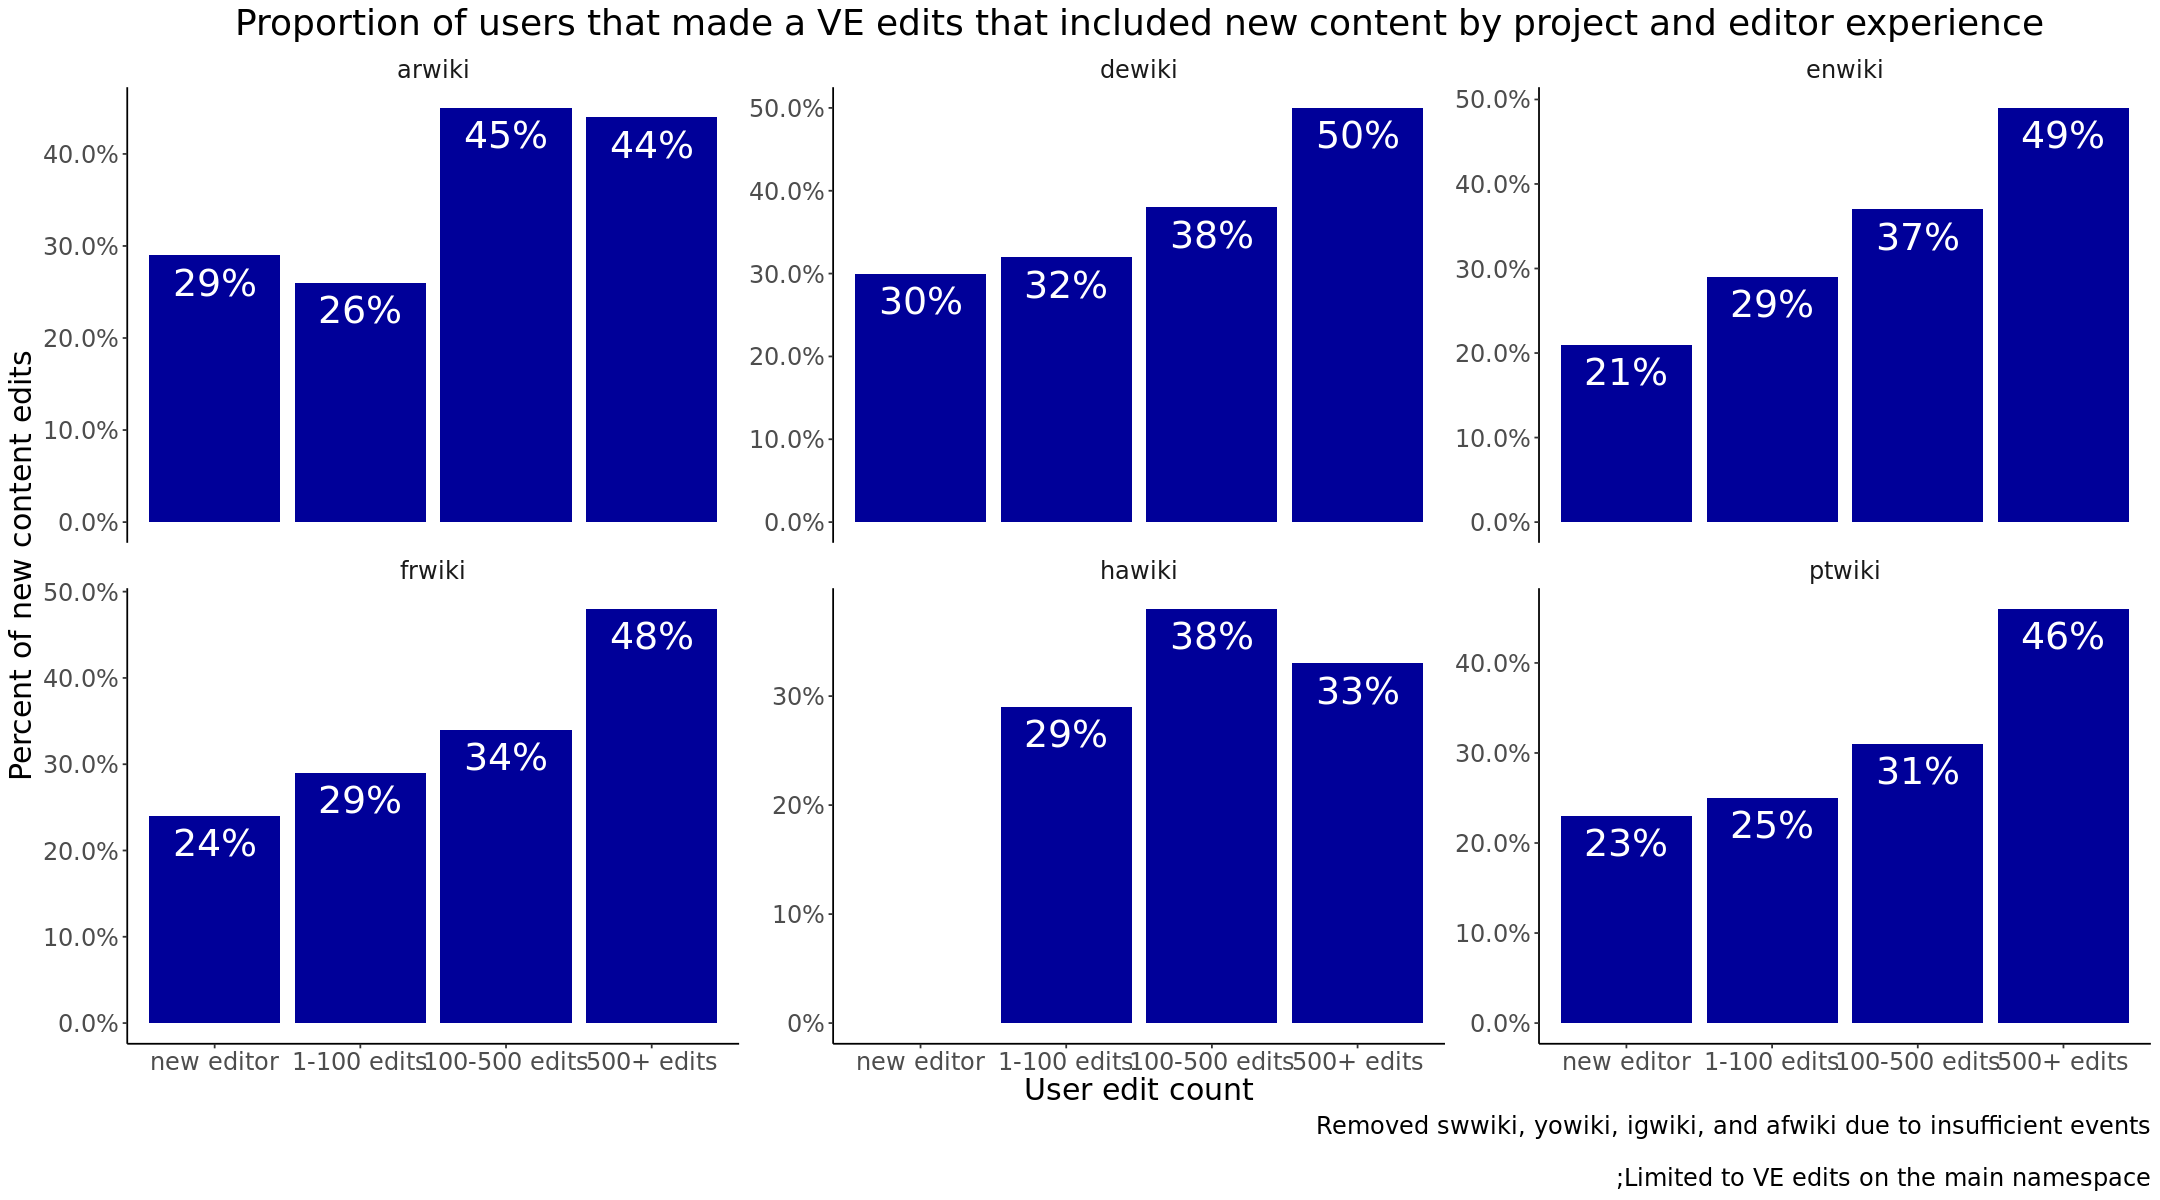

In [36]:

p <- ve_new_content_exp_wiki_user %>% 
         filter(!wiki %in% c('swwiki', 'yowiki', 'igwiki', 'afwiki')) %>%
        ggplot(aes(x = user_edit_count_group, y= pct_new_content_users)) +
        geom_col(position = 'dodge', fill = '#000099') +
        geom_text(aes(label = paste0(pct_new_content_users * 100,'%')), color = "white", vjust=1.5, size = 8) +
        facet_wrap(~wiki, scales = "free_y") +
        labs (x = "User edit count",
              y = "Percent of new content edits",
             title = "Proportion of users that made a VE edits that included new content by project and editor experience",
             caption = "Removed swwiki, yowiki, igwiki, and afwiki due to insufficient events
            \n ;Limited to VE edits on the main namespace") +
        scale_y_continuous(labels = scales::percent) +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=18),
            axis.line = element_line(colour = "black"),
            legend.position = "none")
      
p


# What percentage of these edits are reverted?

## Overall

### New content edits

In [37]:
ve_new_content_byrevert <- new_content_edit_data %>%
    summarise(
        n_edits_w_content = n_distinct(rev_id[includes_new_content > 0]),
        n_edit_w_conent_reverted = n_distinct(rev_id[includes_new_content > 0 & is_reverted_48hrs > 0]),
        pct_new_content_edits = n_edit_w_conent_reverted/n_edits_w_content * 100)

ve_new_content_byrevert

n_edits_w_content n_edit_w_conent_reverted pct_new_content_edits
1 88523             9172                     10.36115

### Non new content edits

In [40]:
ve_non_content_byrevert <- new_content_edit_data %>%
    summarise(
        n_edits_w_content = n_distinct(rev_id[includes_new_content == 0]),
        n_edit_w_conent_reverted = n_distinct(rev_id[includes_new_content == 0 & is_reverted_48hrs > 0]),
        pct_new_content_edits = n_edit_w_conent_reverted/n_edits_w_content * 100)

ve_non_content_byrevert

n_edits_w_content n_edit_w_conent_reverted pct_new_content_edits
1 592396            47512                    8.020311

10.4% of all new content edits made with VE on a main namespace are reverted within 48 hours compared to about 8% of other edit types made with VE.

## Revert rate by Experience Level
Limited to edits reverted within 48 hours

### New Content Edits

In [ ]:
ve_new_content_byrevert_exp <- new_content_edit_data %>%
    group_by(user_edit_count_group) %>%
    summarise(
        n_edits_w_content = n_distinct(rev_id[includes_new_content > 0]),
        n_edit_w_conent_reverted = n_distinct(rev_id[includes_new_content > 0 & is_reverted_48hrs > 0]),
        pct_new_content_edits = round(n_edit_w_conent_reverted/n_edits_w_content,2))

ve_new_content_byrevert_exp

### Non New Content Edits

In [ ]:
ve_non_content_byrevert_exp <- new_content_edit_data %>%
    group_by(user_edit_count_group) %>%
    summarise(
        n_edits_non_content = n_distinct(rev_id[includes_new_content == 0]),
        n_edit_non_content_reverted = n_distinct(rev_id[includes_new_content == 0 & is_reverted_48hrs > 0]),
        pct_non_content_edits = round(n_edit_non_content_reverted/n_edits_non_content,2))

ve_non_content_byrevert_exp

In [ ]:
# Combine Table
new_content_byrevert_exp <- ve_new_content_byrevert_exp %>%
    inner_join(ve_non_content_byrevert_exp , by = "user_edit_count_group") %>%
    select(c(1,4,7)) %>% 
    gather("content_included","proportion_reverted", -user_edit_count_group) %>%
    mutate(content_included =  factor(content_included,
         levels = c( "pct_non_content_edits", "pct_new_content_edits"),
         labels = c("Does not include new content", "Includes new content"))) %>%
    arrange(user_edit_count_group)

new_content_byrevert_exp

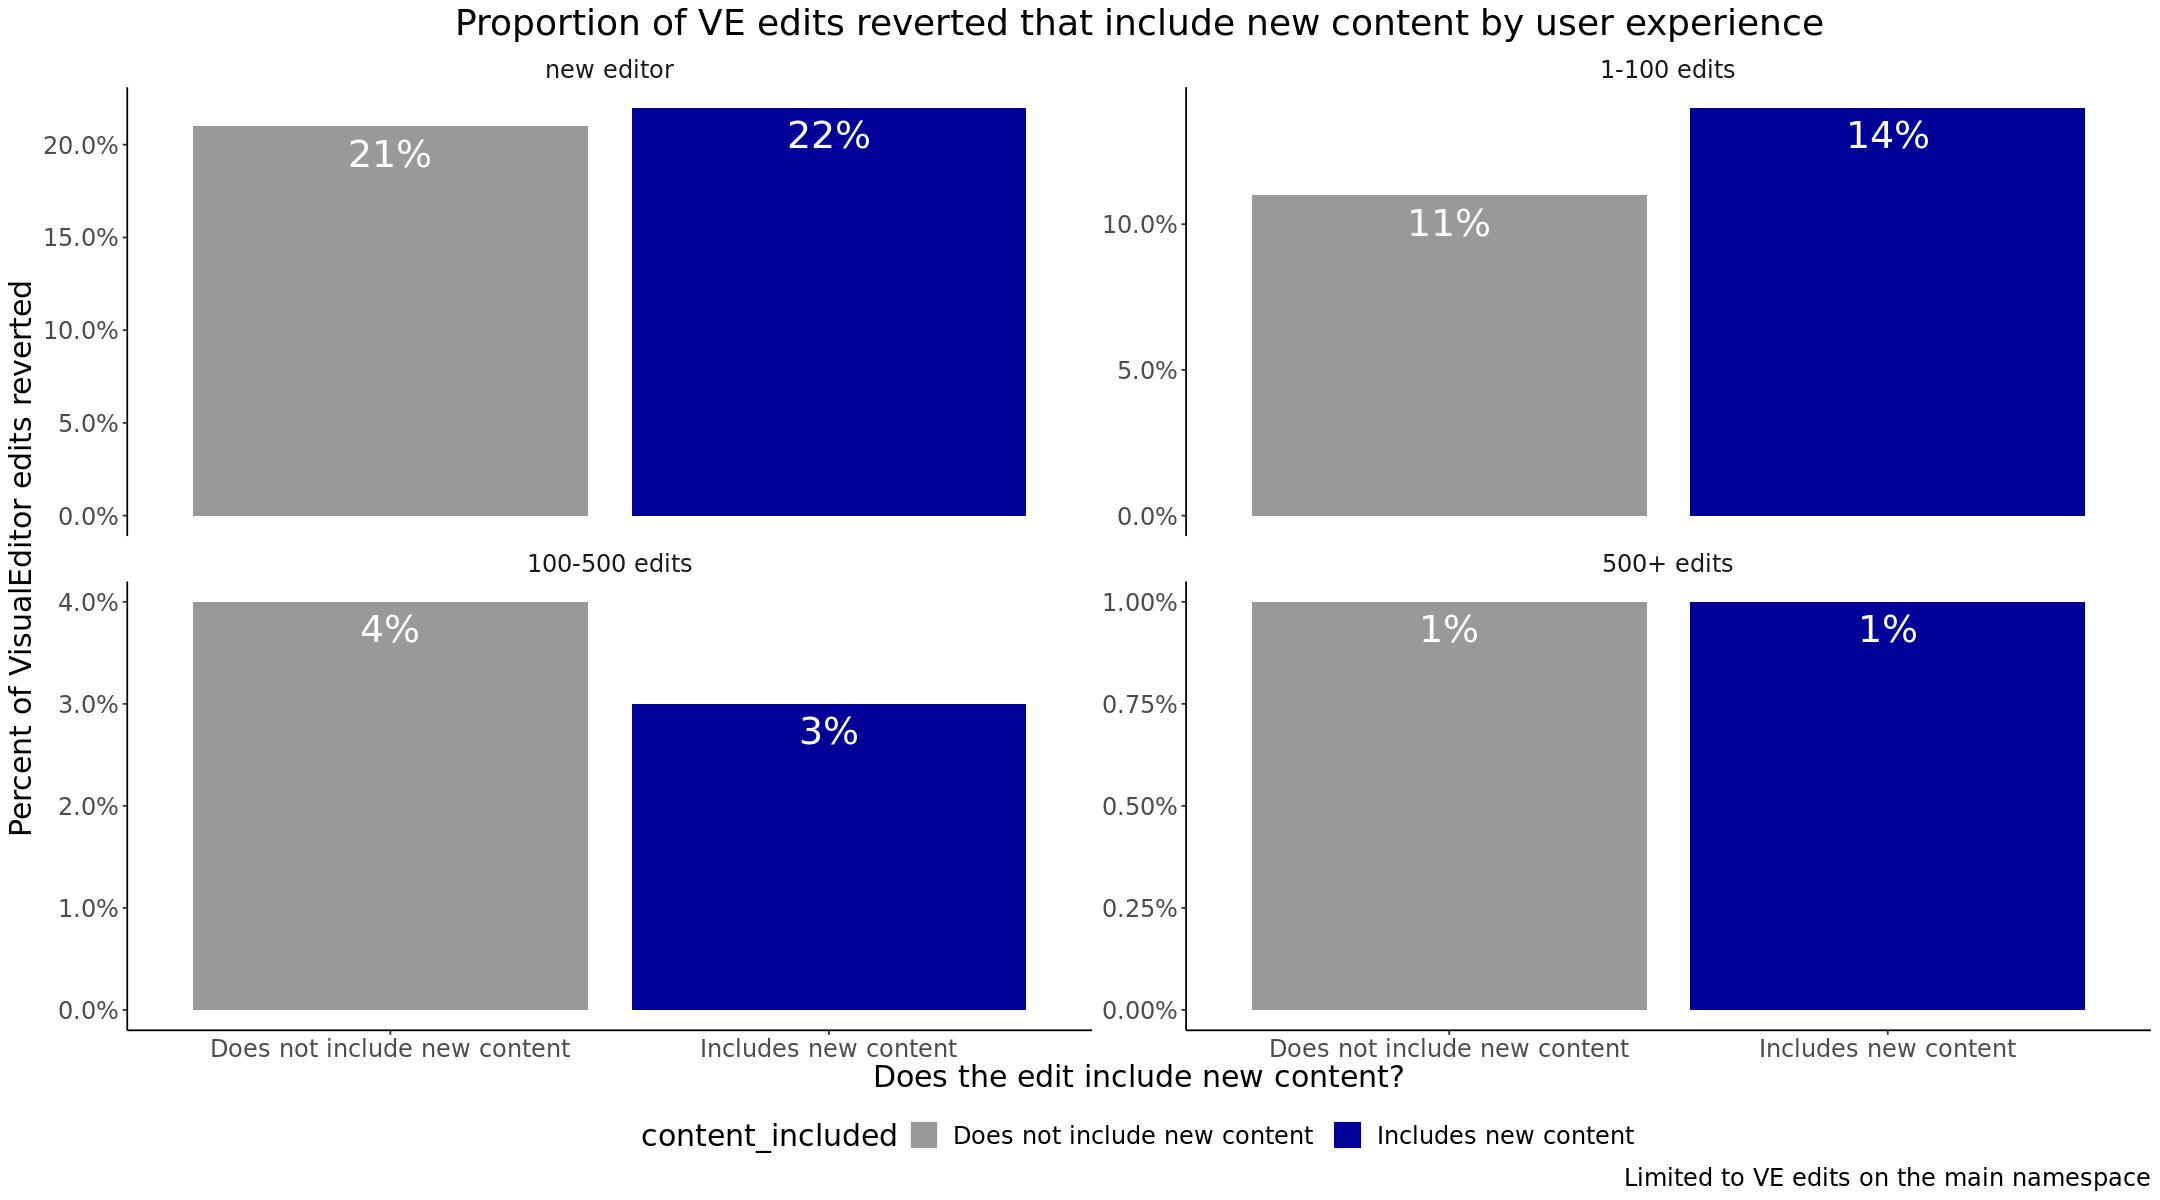

In [73]:
options(repr.plot.width = 18, repr.plot.height = 10)
p <- new_content_byrevert_exp %>% 
        filter(user_edit_count_group != 'NA') %>% #remove logged-out users
        ggplot(aes(x = content_included, y= proportion_reverted, fill = content_included)) +
        geom_col(position = 'dodge') +
        geom_text(aes(label = paste0(round(proportion_reverted * 100, 2),'%')), color = "white", vjust=1.5, size = 8) +
        facet_wrap(~user_edit_count_group, scales = "free_y") +
        labs (x = "Does the edit include new content?",
              y = "Percent of VisualEditor edits reverted",
             title = "Proportion of VE edits reverted that include new content by user experience",
             caption = "Limited to VE edits on the main namespace") +
        scale_y_continuous(labels = scales::percent) +
    scale_fill_manual(values= c("#999999", "#000099"))  + 
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=18),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
      
p


* Edits by new editors and Junior Contributors (under 100 edits) that include new content are more likely to be reverted than edits without new content. There is only a slight percent increase in the revert rate of new content edits by new editors (4.8% increase, 21% → 22%) and a higher percent increase in the revert rate of new content edits by junior editors (27.3% increase, 11% → 14%) 

## Revert Rate By Wiki

### New content edits

In [ ]:
ve_new_content_byrevert_wiki <- new_content_edit_data %>%
 filter(wiki %in% c('enwiki', 'frwiki', 'swwiki', 'arwiki', 'ptwiki', 'hawiki', 
                       'igwiki', 'afwiki', 'yowiki', 'dewiki'))%>%
    group_by(wiki) %>%
    summarise(
        n_edits_w_content = n_distinct(rev_id[includes_new_content > 0]),
        n_edit_w_conent_reverted = n_distinct(rev_id[includes_new_content > 0 & is_reverted_48hrs > 0]),
        pct_new_content_edits = round(n_edit_w_conent_reverted/n_edits_w_content,2))

ve_new_content_byrevert_wiki 

### Non New Content Edits

In [ ]:
ve_non_content_byrevert_wiki <- new_content_edit_data %>%
 filter(wiki %in% c('enwiki', 'frwiki', 'swwiki', 'arwiki', 'ptwiki', 'hawiki', 
                       'igwiki', 'afwiki', 'yowiki', 'dewiki'))%>%
    group_by(wiki) %>%
    summarise(
        n_edits_non_content = n_distinct(rev_id[includes_new_content == 0]),
        n_edit_non_content_reverted = n_distinct(rev_id[includes_new_content == 0 & is_reverted_48hrs > 0]),
        pct_non_content_edits = round(n_edit_non_content_reverted/n_edits_non_content,2))

ve_non_content_byrevert_wiki

In [ ]:
# Combine Table
new_content_byrevert_wiki <- ve_new_content_byrevert_wiki %>%
    inner_join(ve_non_content_byrevert_wiki , by = "wiki") %>%
    select(c(1,4,7)) %>% 
    gather("content_included","proportion_reverted", -wiki) %>%
    mutate(content_included =  factor(content_included,
         levels = c( "pct_non_content_edits", "pct_new_content_edits"),
         labels = c("Does not include new content", "Includes new content"))) %>%
    arrange(wiki)

new_content_byrevert_wiki

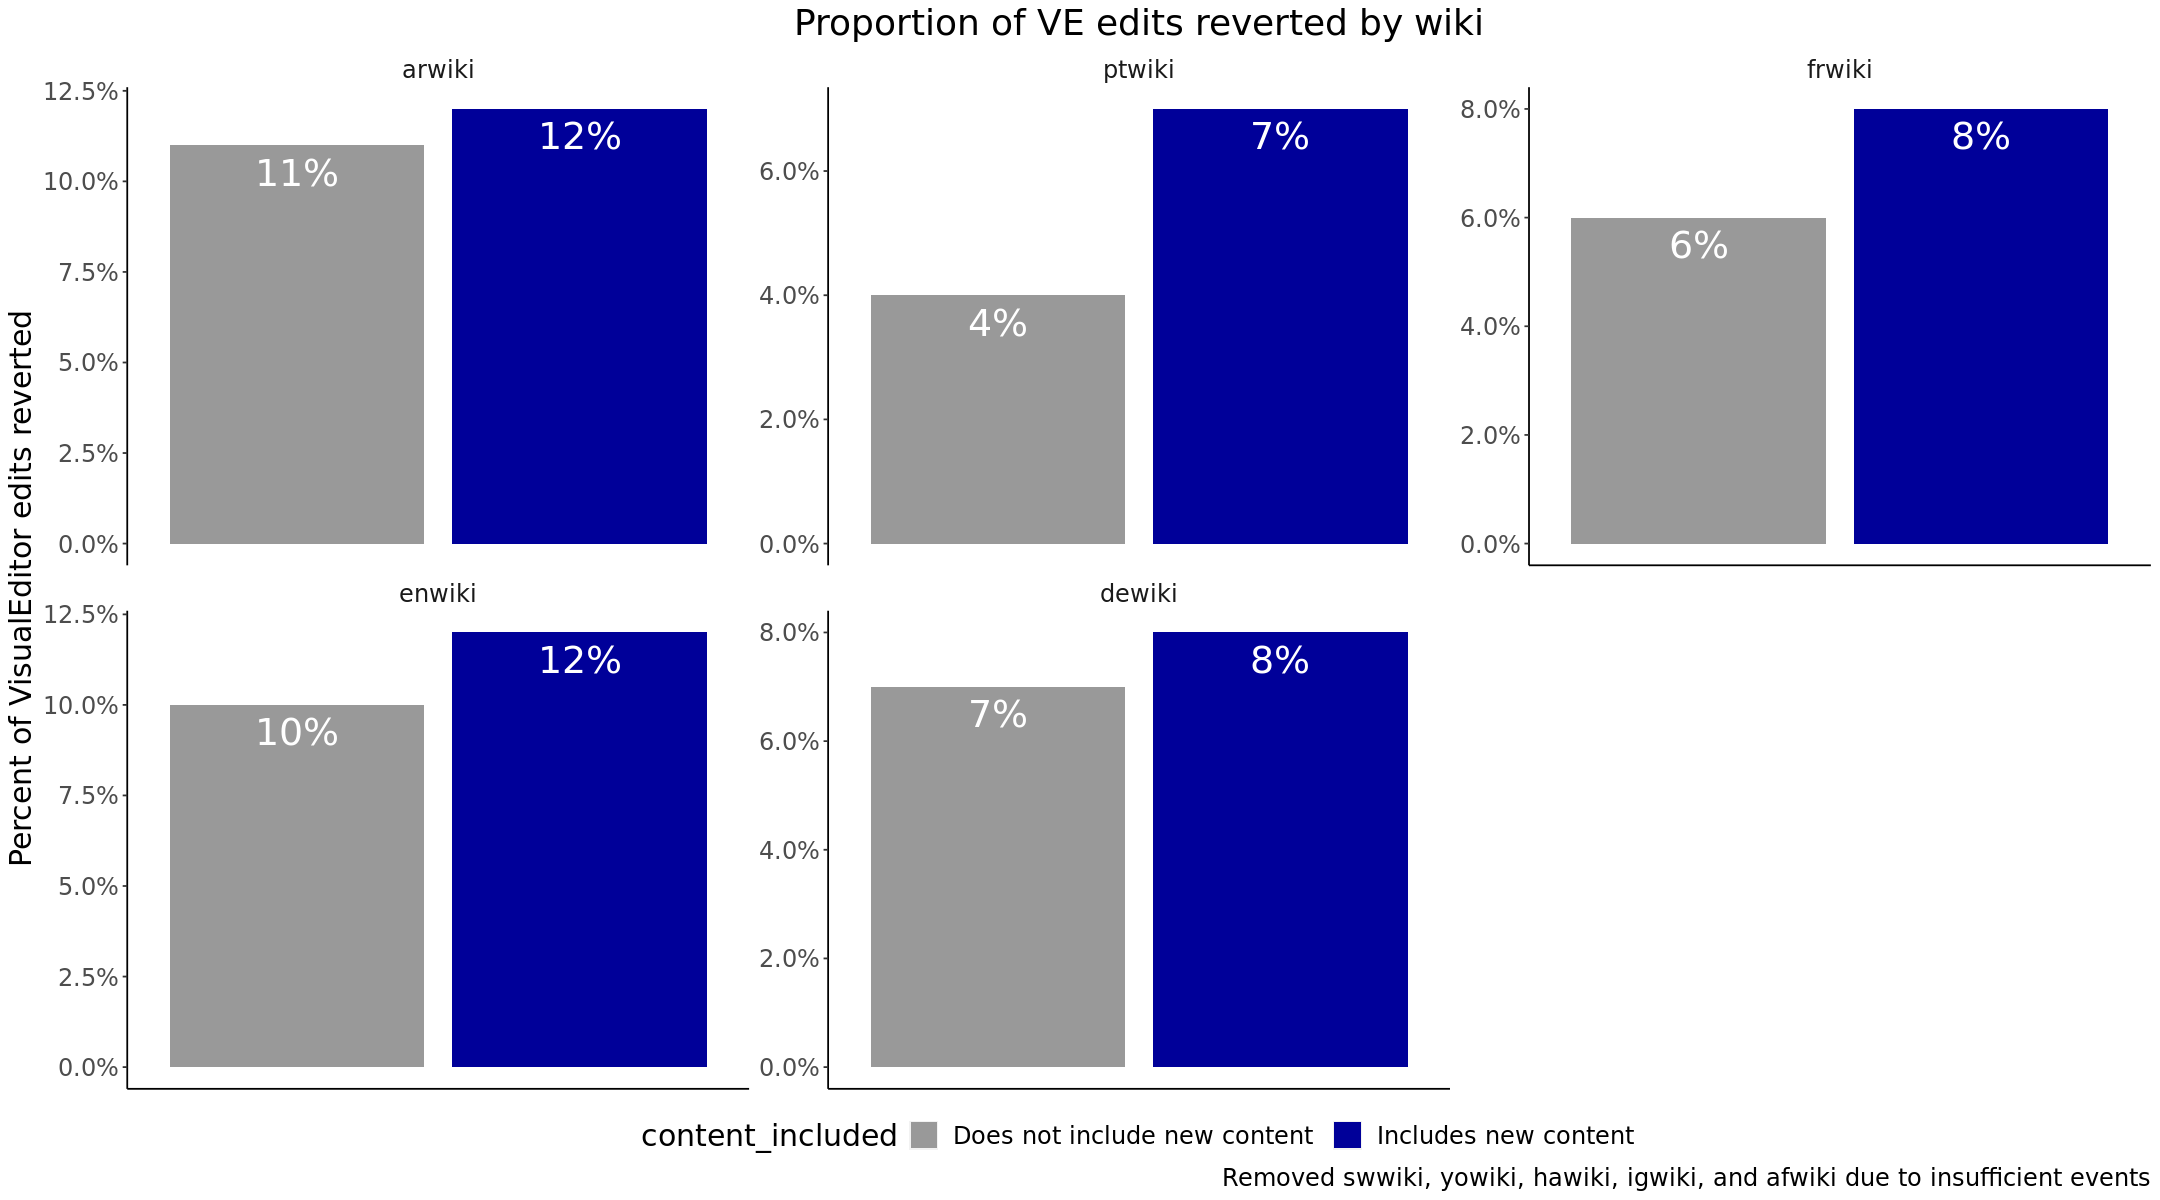

In [72]:
options(repr.plot.width = 18, repr.plot.height = 10)
p <- new_content_byrevert_wiki %>% 
      filter(!wiki %in% c('swwiki','hawiki', 'yowiki', 'igwiki', 'afwiki')) %>%
        ggplot(aes(x = content_included, y= proportion_reverted, fill = content_included)) +
        geom_col(position = 'dodge') +
        geom_text(aes(label = paste0(round(proportion_reverted * 100, 2),'%')), color = "white", vjust=1.5, size = 8) +
        facet_wrap(~wiki, scales = "free_y") +
        labs (x = "Does the edit include new content",
              y = "Percent of VisualEditor edits reverted",
             title = "Proportion of VE edits reverted by wiki",
             caption = "Removed swwiki, yowiki, hawiki, igwiki, and afwiki due to insufficient events") +
        scale_y_continuous(labels = scales::percent) +
    scale_fill_manual(values= c("#999999", "#000099"))  + 
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=18),
            axis.line = element_line(colour = "black"),
            axis.title.x=element_blank(),
            axis.text.x=element_blank(),
            axis.ticks.x=element_blank(),
            legend.position = "bottom")
      
p


We see similar trends at each reviewed project. Overall across all editor experiences, VE edits with new content are more likely to be reverted than edits without new content; however, there is some variation in the percent difference at each wiki. 